### This script contains the following:

#### 1. Importing your libraries and data
#### 2. Subsetting, wrangling, and cleaning time-series data
#### 3. Time series analysis: decomposition
#### 4. Testing for stationarity
#### 5. Stationarizing the Federal Reserve Economic Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import os
import warnings 
warnings.filterwarnings("ignore") 
plt.style.use('fivethirtyeight') 

In [2]:
path = r'/Users/niravbariya/Documents/Data Science/CareerFoundry/Data Analytics Immersion/Achievement 6'

In [6]:
# Importing the cleaned toronto_listings file
df = pd.read_csv(os.path.join(path,'02 Data','Prepared Data','toronto_clustered_clean.csv'))

In [7]:
pd.set_option('display.max_columns',None)

In [8]:
df.head()

,Unnamed: 0,id,scrape_id,host_id,host_since,host_response_rate,host_acceptance_rate,host_is_superhost,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,listings_count,listings_count_home,listings_count_p_rooms,listings_count_s_rooms,reviews_per_month,clusters,cluster
0,0,26654,20240214201029,113345,2010-04-25,100.000000,41.000000,0,1,Waterfront Communities-The Island,43.64608,-79.39032,Entire condo,Entire home/apt,4,1.0,1.0,2.0,"[""Building staff"", ""Microwave"", ""Central air c...",164.0,28,1125,1,0,0,0,115,2024-02-15,42,2,0,4.790000,4.790000,4.790000,4.640000,4.760000,4.860000,4.670000,f,5,5,0,0,0.260000,3,purple
1,1,27423,20240214201029,118124,2010-05-04,100.000000,100.000000,0,1,South Riverdale,43.66884,-79.32725,Entire rental unit,Entire home/apt,1,1.0,0.0,1.0,"[""Free street parking"", ""Microwave"", ""Central ...",75.0,90,365,1,10,13,13,146,2024-02-15,28,1,0,4.930000,5.000000,4.850000,5.000000,5.000000,4.850000,4.850000,f,1,1,0,0,0.170000,3,purple
2,2,335446,20240214201029,1704172,2012-02-05,100.000000,100.000000,1,1,Moss Park,43.65744,-79.37228,Private room in condo,Private room,1,1.0,1.0,1.0,"[""Microwave"", ""Central air conditioning"", ""Fre...",100.0,28,1125,1,0,0,2,277,2024-02-15,121,1,0,4.850000,4.720000,4.700000,4.970000,4.960000,4.530000,4.780000,t,2,1,1,0,0.830000,3,purple
3,3,339418,20240214201029,1027776,2011-08-27,95.848253,85.081771,0,1,Mount Pleasant West,43.69954,-79.39330,Private room in rental unit,Private room,2,1.0,1.0,0.0,"[""Free street parking"", ""Microwave"", ""Shared s...",60.0,28,90,1,0,0,0,0,2024-02-15,85,0,0,4.500000,4.330000,4.110000,4.590000,4.670000,4.650000,4.360000,f,1,0,1,0,0.580000,3,purple
4,4,42892,20240214201029,187320,2010-08-01,100.000000,44.000000,1,1,Waterfront Communities-The Island,43.64450,-79.38019,Entire condo,Entire home/apt,4,2.0,3.0,3.0,"[""Lake access"", ""Long term stays allowed"", ""Ho...",140.0,30,365,1,29,59,89,364,2024-02-15,0,0,0,4.788366,4.810071,4.810071,4.855948,4.867068,4.832452,4.688679,f,12,7,5,0,1.509953,3,purple


In [9]:
df.shape

(15235, 46)

In [10]:
df.columns

Index(['Unnamed: 0', 'id', 'scrape_id', 'host_id', 'host_since',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_identity_verified', 'neighbourhood_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights',
       'maximum_nights', 'has_availability', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'calendar_last_scraped', 'number_of_reviews', 'number_of_reviews_ltm',
       'number_of_reviews_l30d', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'instant_bookable',
       'listings_count', 'listings_count_home', 'listings_count_p_rooms',
       'listings_count_s_rooms', 'reviews_per_month', 'clusters', 'cluster'],
      dtype='object')

### 2. Subsetting, wrangling, and cleaning time-series data

In [37]:
data = df[['host_since','host_id']]

In [38]:
# Checking for duplicates
data.duplicated().sum()

5690

There could possibly be duplicate values in this case as we are only looking at host_since and host_id column. However, as we have checked earlier the entire dataframe doesn't have any duplicates.

In [39]:
# Checking for null values
data.isnull().sum()

host_since    0
host_id       0
dtype: int64

In [40]:
# Converting host_since to datetime data type
data['host_since'] = pd.to_datetime(data['host_since'])

In [41]:
data['year'] = data['host_since'].dt.year

In [42]:
# Counting host_ids by year data by year
data = data.groupby('year')['host_id'].nunique().reset_index()

In [43]:
data.head()

,year,host_id
0,2009,9
1,2010,50
2,2011,174
3,2012,345
4,2013,502


In [44]:
# Set the datetime as the index of the dataframe.
data= data.set_index('year') 

In [45]:
# Removing 2009 and 2024 as these years may have extremely low values
data = data[(data.index != 2021)& (data.index !=2024)]

In [46]:
data.head()

,host_id
year,
2009,9
2010,50
2011,174
2012,345
2013,502


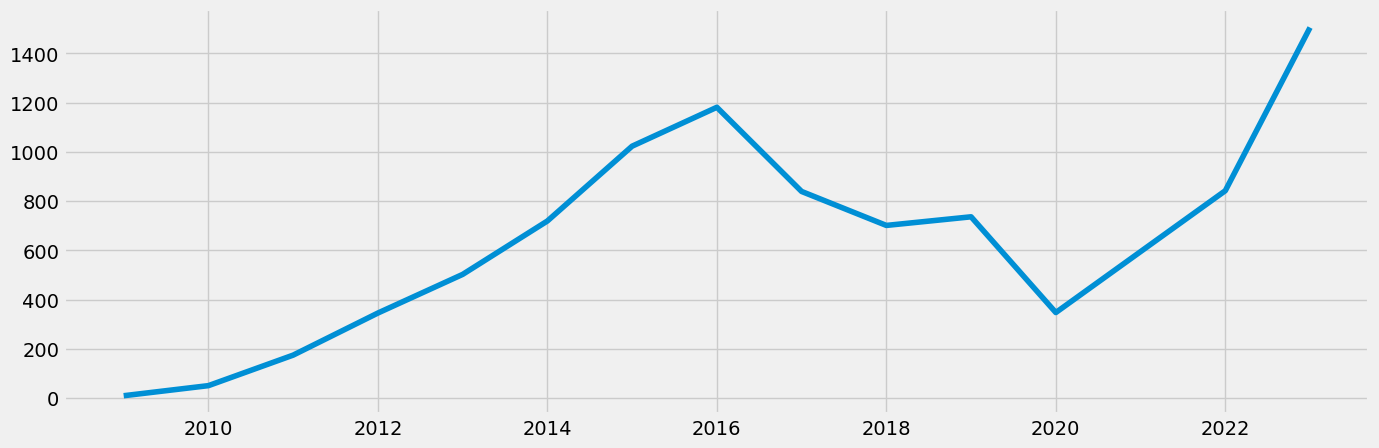

In [47]:
# Plot the new data set
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data)

### 3. Time-series analysis: decomposition

In [48]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data, model='additive',period=1)

In [49]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

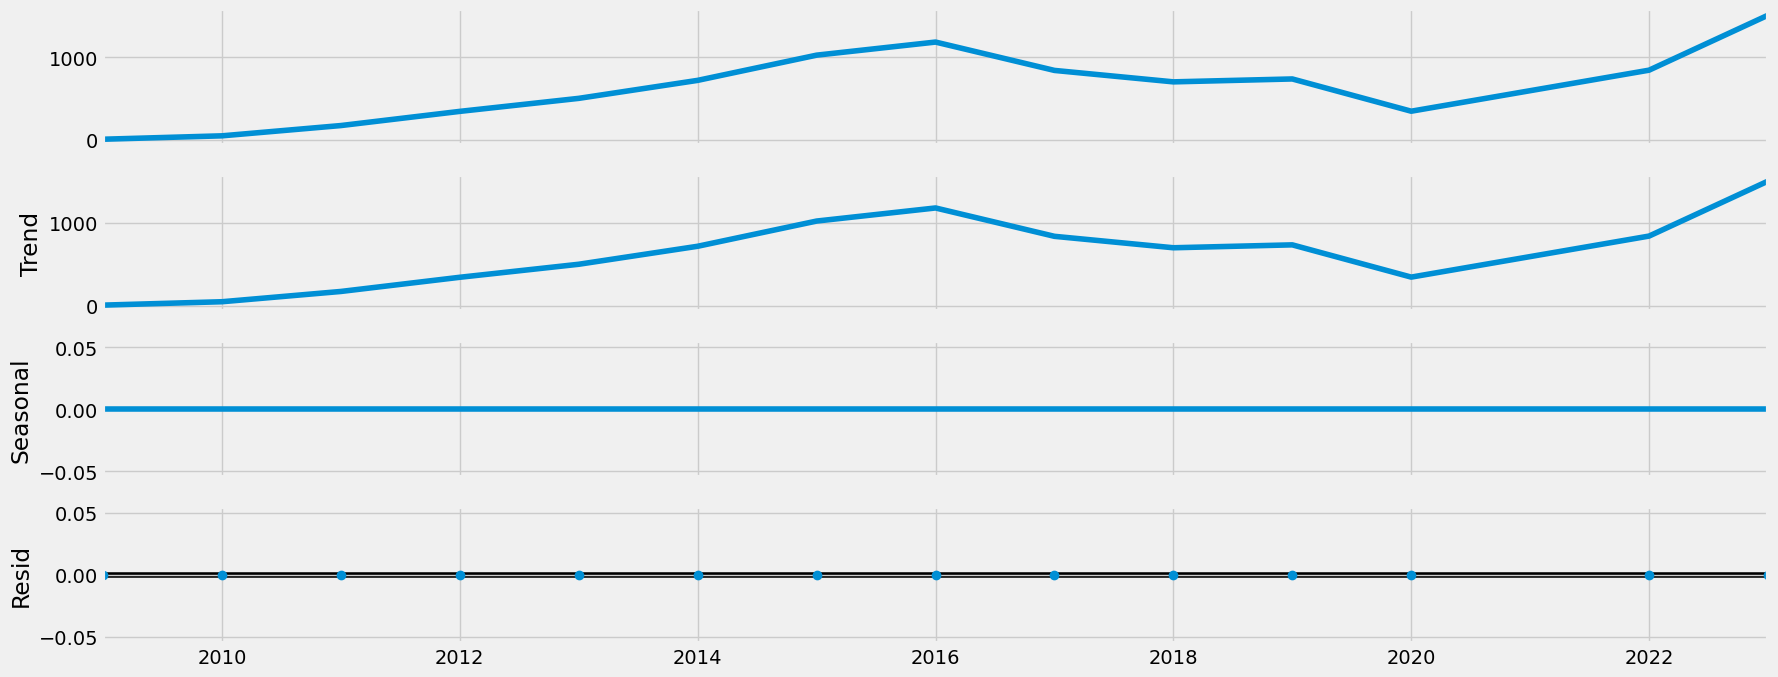

In [50]:
# Plot the separate components

decomposition.plot()
plt.show()

Note that, after decomposition we don't observe any seasonality in the data and there are no residuals in the data as it's a flat curve. The trend is same as the original series also known as level. This means that there is no unexplained noise or variance in the data. We can infer that our time series might be stationary but we will have to prove that using a statistical method.

### 4. Testing for stationarity

In [51]:
# Dicket-Fuller Test 

from statsmodels.tsa.stattools import adfuller 

def dickey_fuller(timeseries): 
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

dickey_fuller(data['host_id'])

Dickey-Fuller Stationarity test:
Test Statistic                -1.707496
p-value                        0.427254
Number of Lags Used            4.000000
Number of Observations Used    9.000000
Critical Value (1%)           -4.473135
Critical Value (5%)           -3.289881
Critical Value (10%)          -2.772382
dtype: float64


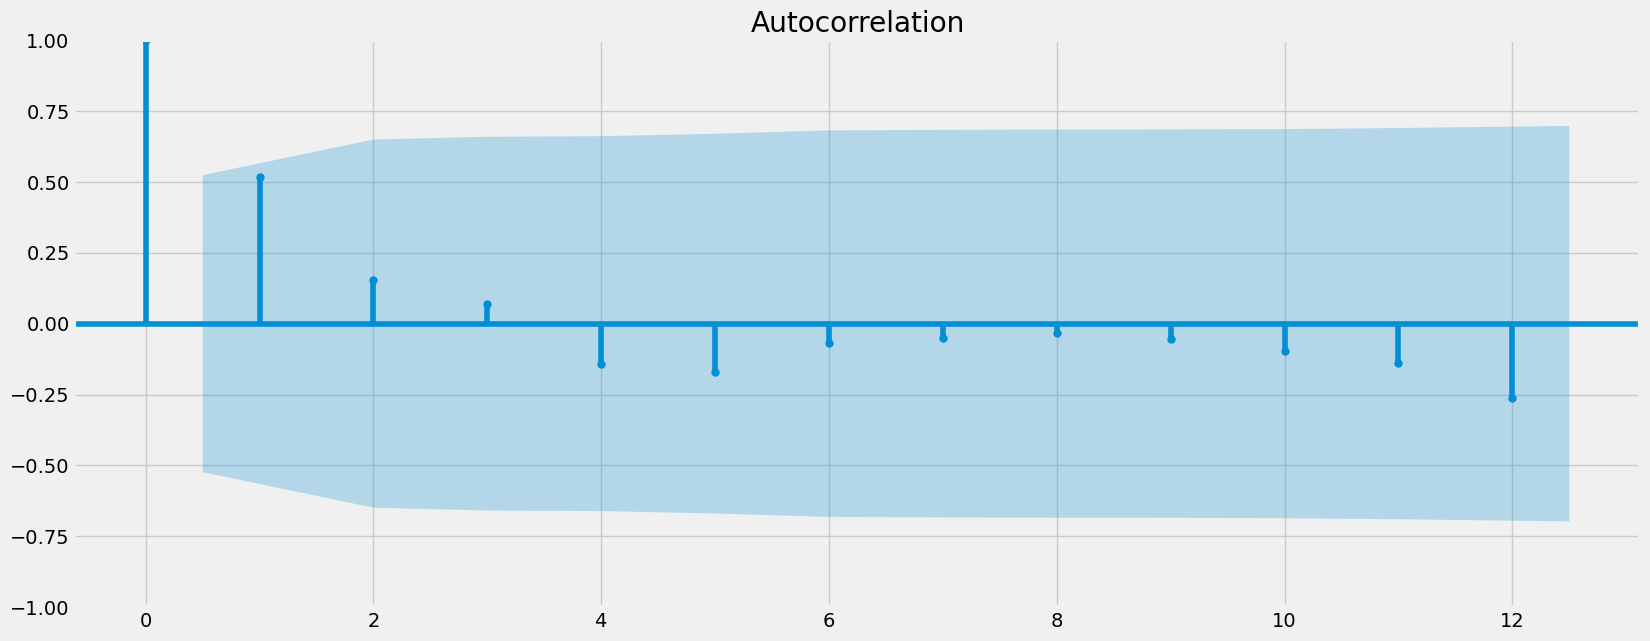

In [52]:
# Check out a plot of autocorrelations
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data)
plt.show()

There is no autocorrelation in our data points. Thus, we only have to deal with non-stationarity of the time series.

### 5. Stationarizing

In [53]:
# Creating a differenciated time series
data_diff = data - data.shift(1) 

In [54]:
# Removing missing values after differencing
data_diff.dropna(inplace = True) 

In [55]:
data_diff.head()

,host_id
year,
2010,41.0
2011,124.0
2012,171.0
2013,157.0
2014,217.0


In [56]:
data_diff.columns

Index(['host_id'], dtype='object')

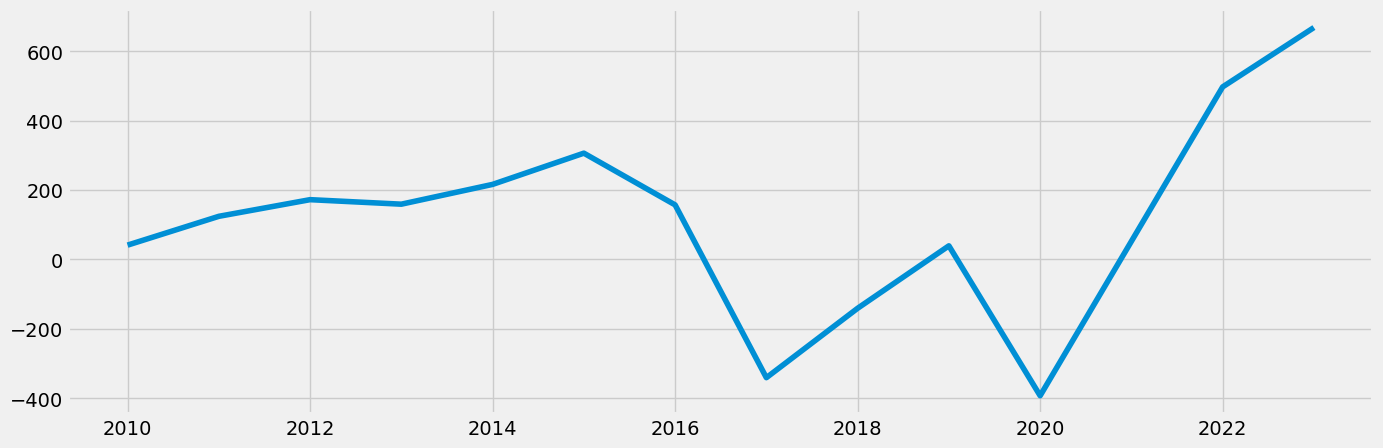

In [83]:
# Plotting the differences

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [57]:
# Re-performing Dicky-Fuller Stationarity Test
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -3.394497
p-value                        0.011148
Number of Lags Used            3.000000
Number of Observations Used    9.000000
Critical Value (1%)           -4.473135
Critical Value (5%)           -3.289881
Critical Value (10%)          -2.772382
dtype: float64


Test Statistic is smaller than critical value at 5% and critical value at 10%. We can **reject null hypothesis that the time series is non-stationary with 95% confidence.** Thus, our time series after differencing has become stationary.

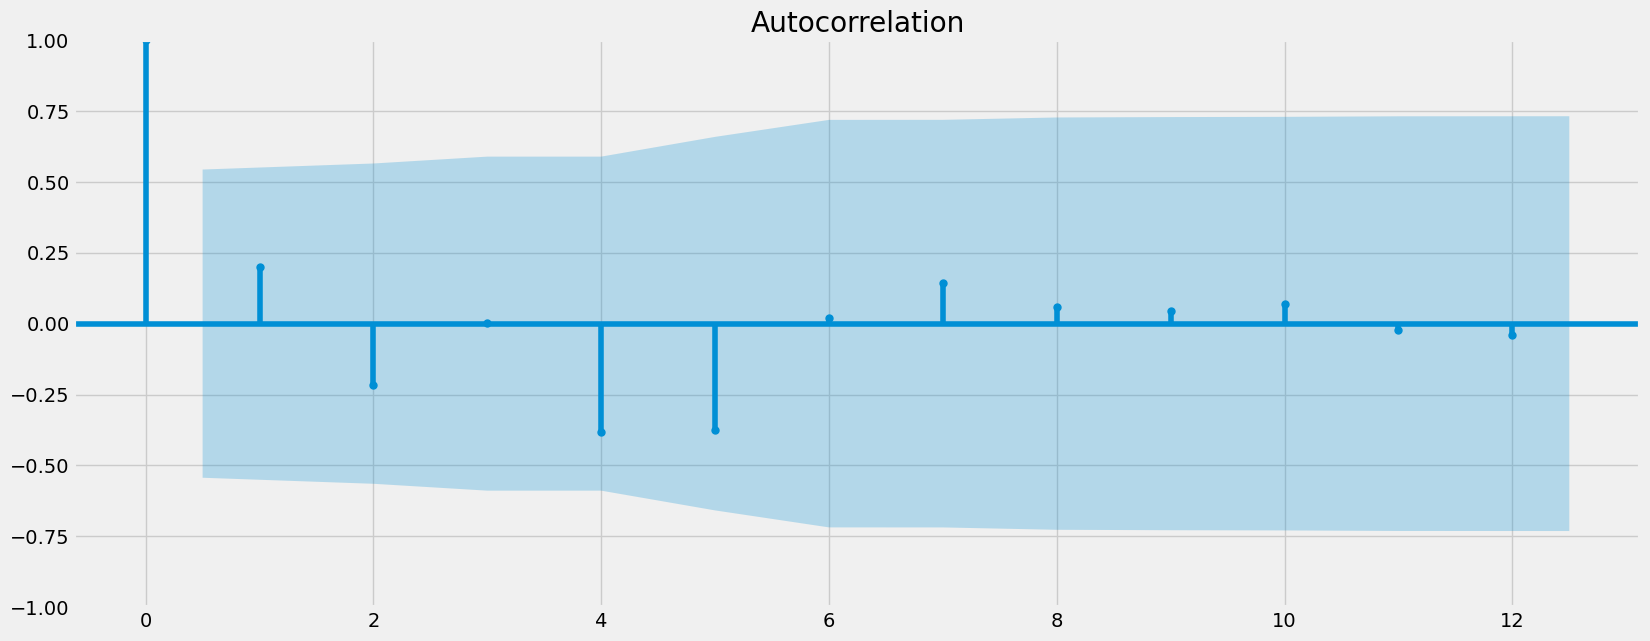

In [58]:
plot_acf(data_diff)
plt.show()

There is no autocorrelation in our time series. We can say that our time series is stationary.